In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime,date
import seaborn as sns
import pickle
import math

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy.stats import ttest_ind
import researchpy as rp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings

# Predicting Kickstarter Campaign Success
### An exploration of campaign data from the largest crowdfunding platform

### By Anita K.

### Abstract

The purpose of this research is to examine a crowdfunding dataset and gain insight into the factors contributing to the success of kickstart campaigns. The project focus lies on creating a prediction algorithm based on key kickstarter features by applying several of the most common machine learning models. It is suited for beginner to intermediate readers/developers, and as such does not claim to be entirely exhaustive, but rather aims to lay out the fundamental methodology of handling such a task. In addition, the research approach includes testing a hypothesis about the relationship between the desired goal amount of each campaign and its success probability.<br>

### Introduction and Data Acquisition
Kickstarter is a funding platform with a mission to help bring creative projects to life. It supports everything from films, games and music to art, design, and technology. The platform applies an all-or-nothing approach which means that no one will be charged for a pledge towards a project unless it reaches its funding goal. Since its launch in 2009, 17 million people have backed a project, USD 4.7 billion has been pledged, and 173 676 projects have been successfully funded.<br>
That is why it would be a challenging task to analyze that data and use it to build a machine learning classifier predicting whether Kickstarter campaigns would be successful.

**The dataset being used in the project can be downloaded [here](https://drive.google.com/drive/folders/1BvJ4Vt6xpgQmAVTBOwSxuQQY7DT5KCGi?usp=sharing)**. Originally, the data has been obtained by a web scraping service which archives Kickstarter campaign data.<br>

Comments are provided alongside or within the code implementaton, and computationally slow cells have been serialized through pickle for re-running the notebook more easily if needed.<br>
#### Please note that due to excessive size, the Random Forest pickle files have been uploaded externally and can be found [here](https://drive.google.com/file/d/1gnIlt_Dhw-TsU4rt_i9MOIaN6-2u4iXZ/view?usp=sharing).

### Framing the Problem
The main goal that this research will try to achieve is to build several machine learning models predicting kickstarter success, and to evaluate and compare their performance.<br>
Besides modeling, we will test a hypothesis to see if campaign success is correlated with specific campaign goal amounts or not. For that purpose, we will assume a p-value threshold of 0.01 (which means that there is a 1% chance the observed results are coincidental).<br>

#### Previous Research
Multiple high-level research publications and implementations can be found online. The dataset versions being used vary widely both in terms of time period, number and types of features, but there is a dominant common trait of struggle to get the accuracy score as close to 70% as possible. To that end, most researchers resort to the widest possible array of machine learning algorithms and libraries.

### Data Tidying and Cleaning

To begin with, we will inspect our data to determine what extent of cleaning and tidying is necessary.

In [4]:
kickstart_data = pd.read_csv("data/ks-projects-201801.csv", sep = ",")

pd.set_option('display.max_columns', 50)

kickstart_data.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
# Setting the campaign ID as index
kickstart_data.set_index("ID", inplace = True)

In [6]:
kickstart_data.head(5)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [7]:
kickstart_data.shape

(378661, 14)

In [8]:
print("The dataset contains information about", len(kickstart_data), "kickstarter campaigns.")

The dataset contains information about 378661 kickstarter campaigns.


In [9]:
kickstart_data.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

*Removing an extra space from a column name:*

In [10]:
kickstart_data.rename(columns = {"usd pledged": "usd_pledged"}, inplace = True)
kickstart_data.head(1)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95


In [11]:
kickstart_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd_pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(1), object(8)
memory usage: 43.3+ MB


*It would be best to convert all dates to a standard format (datetime):*

In [12]:
# Convert the date columns to datetime format

kickstart_data["launched"] = pd.to_datetime(kickstart_data["launched"])
kickstart_data["deadline"] = pd.to_datetime(kickstart_data["deadline"])
kickstart_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null datetime64[ns]
goal                378661 non-null float64
launched            378661 non-null datetime64[ns]
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd_pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(1), object(6)
memory usage: 43.3+ MB


In [13]:
# Check for null values:
display(kickstart_data.isnull().any())

name                 True
category            False
main_category       False
currency            False
deadline            False
goal                False
launched            False
pledged             False
state               False
backers             False
country             False
usd_pledged          True
usd_pledged_real    False
usd_goal_real       False
dtype: bool

In [14]:
# kickstart_data.isnull().sum() / len(kickstart_data) * 100
kickstart_data.isnull().sum()

name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

### Feature Selection and Feature Engineering

On the topic of data tidying, feature selection and engineering, we will replace all "suspended" and "canceled" campaign statuses with "failed", as it essentially amounts to the same thing. We will drop all "undefined" projects altogether as they would not contribute to the prediction algorithms. Finally, we will drop the "live" projects as well as their status is still pending.<br>
Having observed that our date columns have slightly different formats (the "launched" column includes the hour, whereas the "deadline" column does not), we will first normalize that and then create a new "duration" column using the other two.<br>
Noticing some unexpected dates in the "launch" column (01-01-1970), we will drop those rows suspecting them to be errors filled in by default values.

In [15]:
kickstart_data["state"].replace({"suspended": "failed"}, inplace = True)

In [16]:
kickstart_data["state"].replace({"canceled": "failed"}, inplace = True)

In [17]:
kickstart_data.drop(kickstart_data[kickstart_data.state == "live"].index, inplace=True)

In [18]:
kickstart_data.drop(kickstart_data[kickstart_data.state == "undefined"].index, inplace=True)

In [19]:
kickstart_data.drop(kickstart_data[kickstart_data.name.isnull()].index, inplace=True)

In [20]:
# kickstart_data[kickstart_data.name.isnull()]

In [21]:
kickstart_data["launched"] = pd.to_datetime(kickstart_data["launched"]).dt.normalize()

In [22]:
kickstart_data["launched"].head(5)

ID
1000002330   2015-08-11
1000003930   2017-09-02
1000004038   2013-01-12
1000007540   2012-03-17
1000011046   2015-07-04
Name: launched, dtype: datetime64[ns]

In [23]:
# Creating a new column with campaign duration data

kickstart_data["duration"] = (kickstart_data.deadline - kickstart_data.launched).astype("timedelta64[D]")

In [24]:
kickstart_data["duration"].head(5)

ID
1000002330    59.0
1000003930    60.0
1000004038    45.0
1000007540    30.0
1000011046    56.0
Name: duration, dtype: float64

In [25]:
# kickstart_data["duration"].value_counts()

In [26]:
kickstart_data[kickstart_data["launched"] == "1970-01-01"]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,duration
ID,,,,,,,,,,,,,,,
1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,5000.00,14867.0
1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,15000.00,14835.0
1384087152,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01,0.0,failed,0,US,0.0,0.0,700.00,14750.0
1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,4000.00,14761.0
330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,10000.00,14733.0
462917959,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01,0.0,failed,0,US,0.0,0.0,500.00,14709.0
69489148,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01,0.0,failed,0,CH,0.0,0.0,1905.97,16739.0


In [27]:
kickstart_data.drop(kickstart_data[kickstart_data.launched == "1970-01-01"].index, inplace=True)

**Note:** Project duration is the time chosen by the creator initially for their project, not the amount of time a project takes to reach 100% of its goal. <br>
**Also**, the total project duration allowed by Kickstarter was shortened to 60 days in 2011. Before that point, there was a significant number of projects longer than 60 days:

In [28]:
kickstart_data[kickstart_data["duration"] >= 60].shape

(38179, 15)

In [29]:
# kickstart_data[kickstart_data["duration"] == 61]
kickstart_data["duration"].replace({61: 60}, inplace = True)

**In order to make our models more precise**, we will ignore duration data longer than 60 days, because nowadays that is no longer applicable and such predictions will not be useful.

## Exploring the Data & Plotting Major Variables

Now we will proceed to exploratory data analysis and investigating any interesting interrelationships between the variables.

In [30]:
# Dividing the variables into categorical and constinuous

categ_variables = ["category", "main_category", "currency", "country"]
continuous_variables = ["goal", "pledged", "backers", "usd_pledged", "usd_pledged_real", "usd_goal_real"]

In [31]:
# Continuous variable correlation:

corr = kickstart_data[continuous_variables].corr()

,goal,pledged,backers,usd_pledged,usd_pledged_real,usd_goal_real
goal,1.000000,0.007311,0.004035,0.005599,0.005145,0.941676
pledged,0.007311,1.000000,0.717412,0.858153,0.953367,0.005072
backers,0.004035,0.717412,1.000000,0.697767,0.752478,0.004544
usd_pledged,0.005599,0.858153,0.697767,1.000000,0.908014,0.006244
usd_pledged_real,0.005145,0.953367,0.752478,0.908014,1.000000,0.005643
usd_goal_real,0.941676,0.005072,0.004544,0.006244,0.005643,1.000000


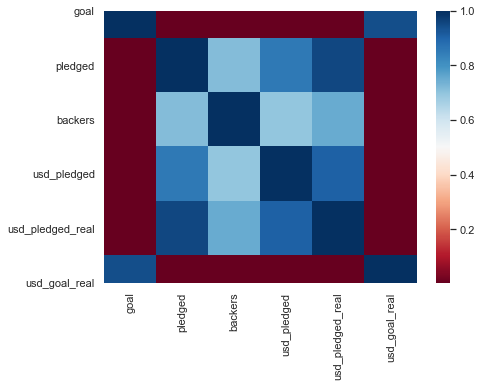

In [32]:
# Display the correlation matrix:
display(corr)

# Plot the correlation heatmap:
sns.set(rc={'figure.figsize':(7,5)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

*Values in the correlation matrix range from 1 (indicating very strong positve correlation) to -1 (very strong negative correlation), via 0 (no relationship).*

### Campaign Status Breakdown

In [33]:
# Set plot style colors
plt.style.use('ggplot')

In [34]:
category_state = kickstart_data.groupby(["state"])
success = category_state.get_group("successful")
# success.shape
success["category"].count()

success_percentage = (success["category"].count() / kickstart_data.shape[0]) * 100
success_percentage = success_percentage.round(decimals=2)

print(str(success_percentage) + " % of all campaigns were successful.")

35.98 % of all campaigns were successful.


In [35]:
kickstart_data["state"].unique()

array(['failed', 'successful'], dtype=object)

In [36]:
campaign_status = kickstart_data.groupby("state").size()
campaign_status.sort_values(ascending = False)

state
failed        238333
successful    133956
dtype: int64

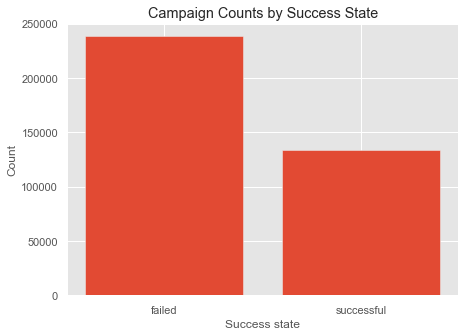

In [37]:
# labels = ["Failed", "Successful", "Canceled", "Undefined", "Live", "Suspended"]
labels = campaign_status.sort_values(ascending = False).index.tolist()
plt.bar(labels, kickstart_data.groupby("state").size().sort_values(ascending=False, inplace=False))

plt.xlabel("Success state")
plt.ylabel("Count")
fig = plt.gcf()
fig.set_size_inches(7, 5)
plt.title('Campaign Counts by Success State')

plt.show()

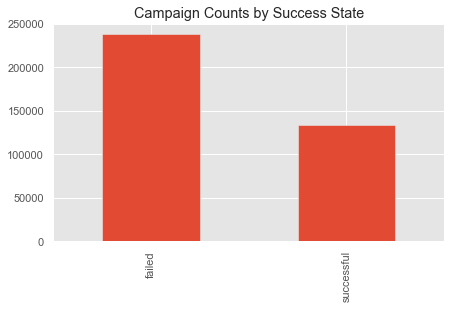

In [38]:
kickstart_data["state"].value_counts().plot(kind = "bar", title = "Campaign Counts by Success State", figsize = (7, 4))

### Most Successful Categories

In [39]:
# Find the category with the most successful projects
success["category"].value_counts().idxmax()

'Product Design'

In [40]:
# Find the Top 15 categories
top_15_categories = success["state"].groupby(success["category"]) \
                .agg(["count"]) \
                .sort_values(["count"], ascending = False) \
                .head(15)

top_15_categories

,count
category,
Product Design,7962
Tabletop Games,7866
Shorts,6673
Music,6432
Documentary,5924
Theater,4405
Indie Rock,3618
Rock,3500
Art,3385


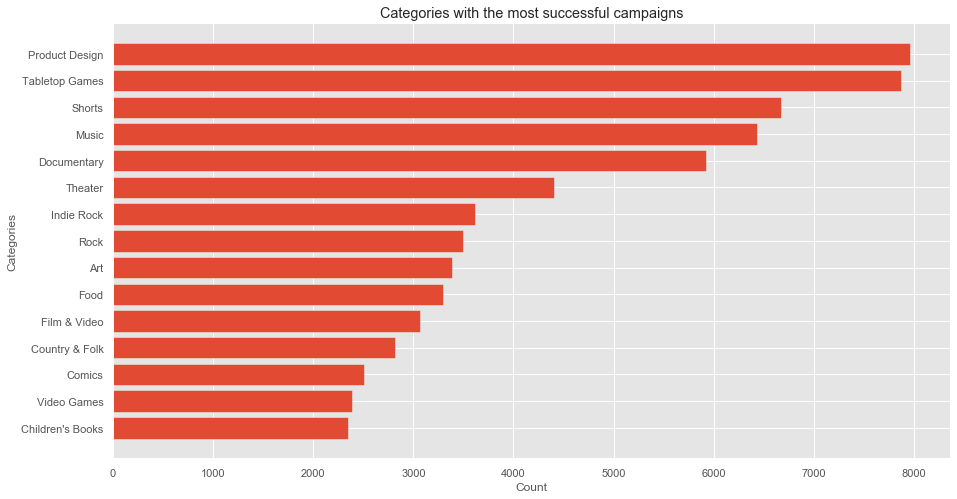

In [41]:
plt.barh(top_15_categories.index.values.tolist(), top_15_categories["count"])
plt.xlabel("Count")
plt.ylabel("Categories")
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Categories with the most successful campaigns')
plt.gca().invert_yaxis()
plt.show()

### Top Countries

In [42]:
top_countries = kickstart_data.groupby("country").size()
top_countries.nlargest(10)

country
US    290878
GB     33392
CA     14624
AU      7769
DE      4096
FR      2887
NL      2833
IT      2802
ES      2224
SE      1737
dtype: int64

In [43]:
kickstart_data["country"].unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'DK', 'BE', 'HK', 'LU', 'SG', 'N,0"',
       'JP'], dtype=object)

#### *Upon closer inspection, it seems a significant number of American campaign locations are listed as their respective state, instead of "US". This could distort the data, so let's fix it now:*

In [44]:
kickstart_data["country"].replace({'N,0"': "US"}, inplace = True)

In [45]:
kickstart_data["country"].unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'DK', 'BE', 'HK', 'LU', 'SG', 'JP'],
      dtype=object)

In [46]:
top_countries = kickstart_data.groupby("country").size()
top_10_countries = top_countries.nlargest(10)

top_10_countries

country
US    291112
GB     33392
CA     14624
AU      7769
DE      4096
FR      2887
NL      2833
IT      2802
ES      2224
SE      1737
dtype: int64

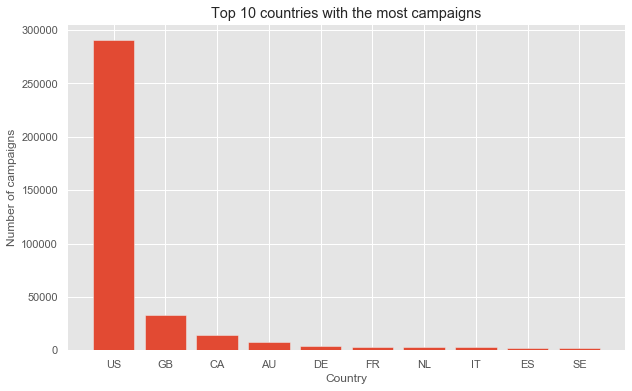

In [47]:
plt.title("Top 10 countries with the most campaigns")
plt.bar(range(10), top_10_countries)
indices = top_10_countries.nlargest(10).index
plt.xticks(range(10), indices)
plt.xlabel("Country")
plt.ylabel("Number of campaigns")
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.show()

### Distribution of campaign success/failure by country

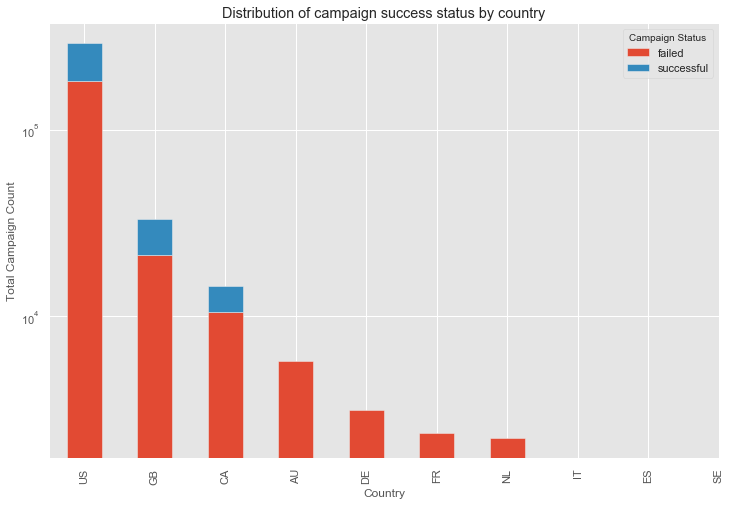

In [48]:
counts = kickstart_data.groupby(['country', 'state']).country.count().nlargest(10).unstack()

counts.plot(kind ='bar', stacked=True)
state = campaign_status.sort_values(ascending = False).index.tolist()

plt.title("Distribution of campaign success status by country")
plt.xlabel("Country")
plt.ylabel("Total Campaign Count")
plt.xticks(np.arange(10), indices)
plt.legend(state, title = "Campaign Status")

fig = plt.gcf()
plt.yscale("log")
fig.set_size_inches(12, 8)
plt.show()

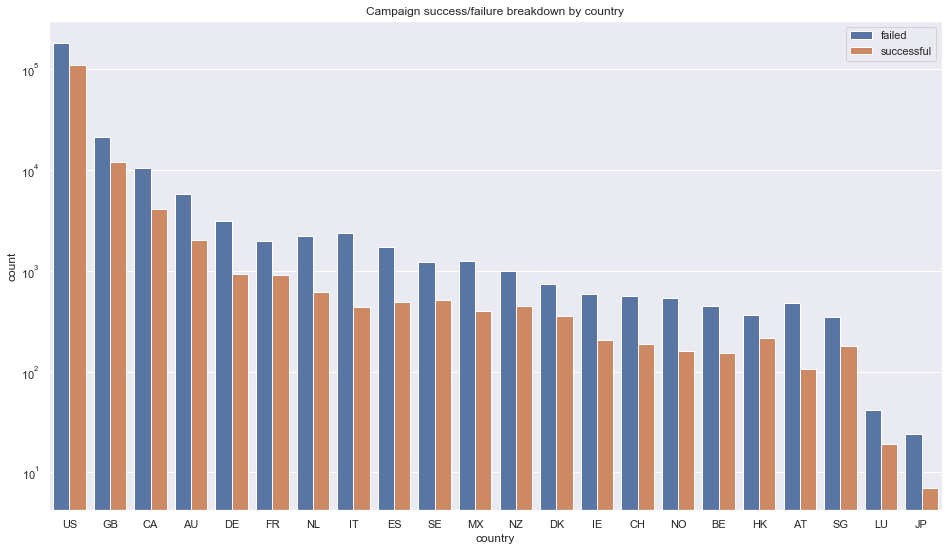

In [49]:
sns.set(rc = {"figure.figsize": (16, 9)})
sns.countplot(x = "country", hue = "state", data = kickstart_data, order = kickstart_data["country"].value_counts().index)
plt.legend(loc = "upper right")
plt.title("Campaign success/failure breakdown by country")
plt.yscale('log')

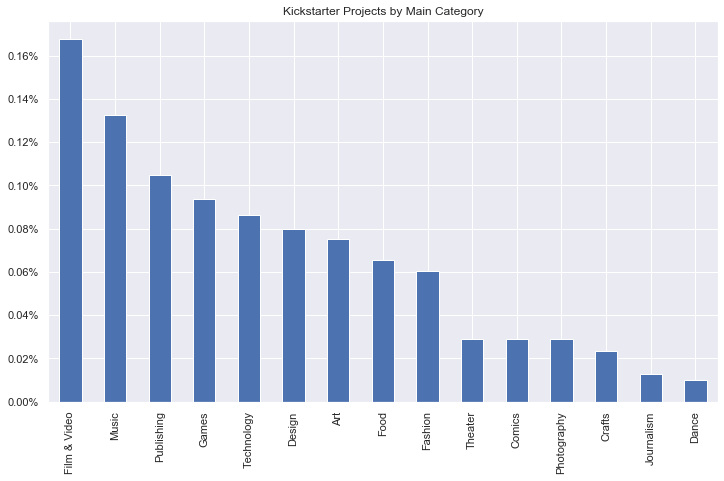

In [50]:
# Projects by Main Category
projects_percent = kickstart_data.main_category.value_counts()/(kickstart_data.shape[0]*100)
ax = projects_percent.plot(kind = "bar", figsize = (12, 7))
plt.title("Kickstarter Projects by Main Category")
vals = ax.get_yticks()
ax.set_yticklabels(["{:,.2%}".format(x) for x in vals])
plt.show()

### Campaign Currency

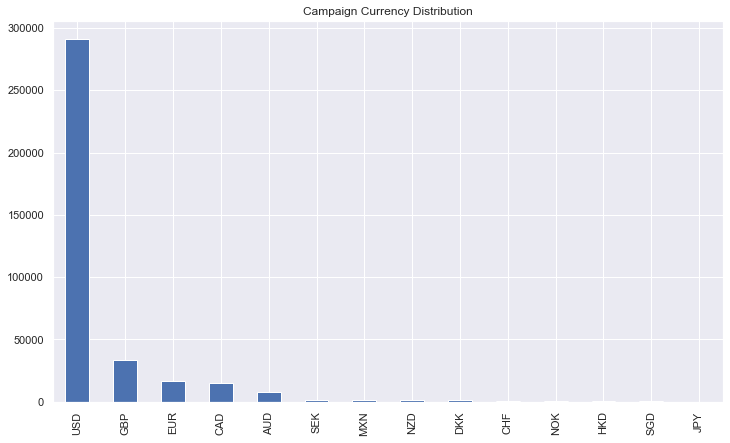

In [51]:
# Non Logarithmic chart

currency_distribution = kickstart_data['currency'].value_counts().plot(kind = "bar", title = "Campaign Currency Distribution", figsize = (12, 7))

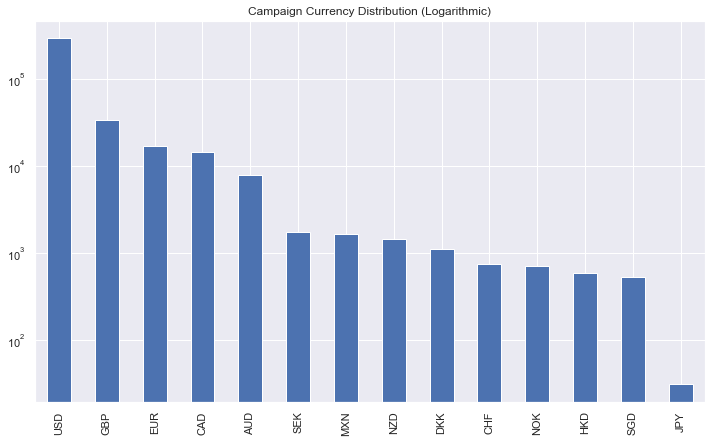

In [52]:
# For comparison - Logarithmic Chart

kickstart_data['currency'].value_counts().plot(kind = "bar", title = "Campaign Currency Distribution (Logarithmic)", figsize = (12, 7))
plt.yscale("log")

### Project Goals

In [53]:
most_common_goals = kickstart_data["usd_goal_real"].value_counts()
most_common_goals.nlargest(10)

5000.0     23599
10000.0    20613
1000.0     12959
3000.0     12356
2000.0     11627
15000.0    11298
20000.0    10042
2500.0      9606
500.0       8536
25000.0     8311
Name: usd_goal_real, dtype: int64

In [54]:
kickstart_data["usd_goal_real"].unique().shape

(49602,)

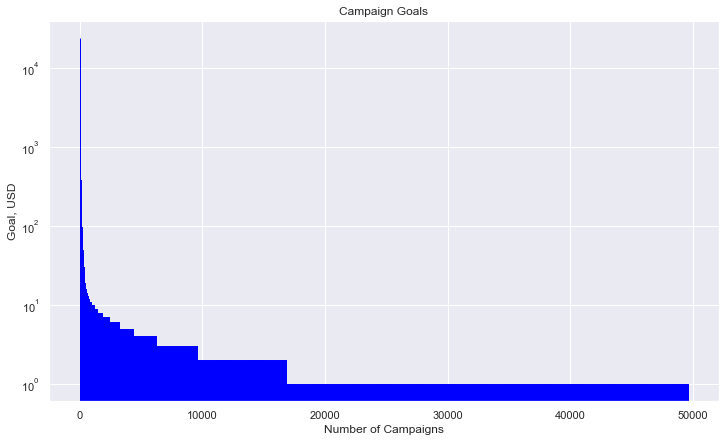

In [55]:
### Plotting the most common campaign goals

goal_labels = kickstart_data["usd_goal_real"].value_counts().index

fig = plt.gcf()
fig.set_size_inches(12, 7)
plt.title('Campaign Goals')
plt.xlabel("Number of Campaigns")
plt.ylabel("Goal, USD")
plt.bar(np.arange(len(goal_labels + 1)), kickstart_data["usd_goal_real"].value_counts(), edgecolor = "blue")
plt.yscale("log")
# plt.savefig("Campaign Goals")

In [56]:
#Defining campaign goal brackets:

up_to_1K = kickstart_data[(kickstart_data["usd_goal_real"] <= 1000)]

up_to_10K = kickstart_data[(kickstart_data["usd_goal_real"] > 1000) & (kickstart_data["usd_goal_real"] <= 10000)]

up_to_50K = kickstart_data[(kickstart_data["usd_goal_real"] > 10000) & (kickstart_data["usd_goal_real"] <= 50000)]

up_to_100K = kickstart_data[(kickstart_data["usd_goal_real"] > 50000) & (kickstart_data["usd_goal_real"] <= 100000)]

up_to_1M = kickstart_data[(kickstart_data["usd_goal_real"] > 100000) & (kickstart_data["usd_goal_real"] <= 1000000) ]

up_to_10M = kickstart_data[(kickstart_data["usd_goal_real"] > 1000000) & (kickstart_data["usd_goal_real"] <= 10000000) ]

above_10M = kickstart_data[(kickstart_data["usd_goal_real"] > 10000000)]

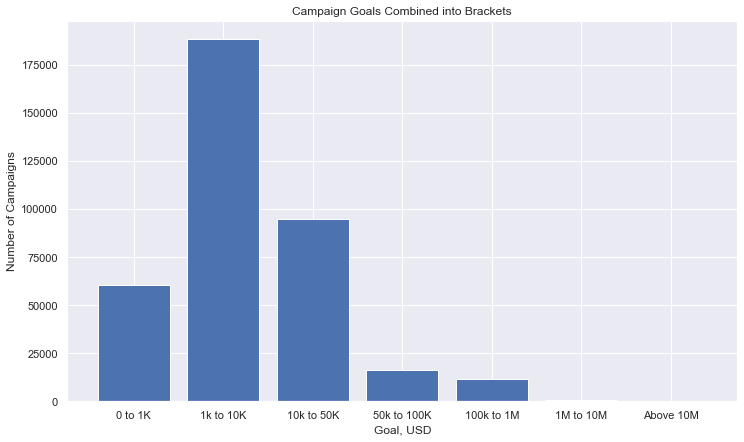

In [57]:
counts = up_to_1K.shape[0], up_to_10K.shape[0], up_to_50K.shape[0],\
                up_to_100K.shape[0], up_to_1M.shape[0],\
                up_to_10M.shape[0], above_10M.shape[0]
labels = ["0 to 1K", "1k to 10K", "10k to 50K", "50k to 100K", "100k to 1M", "1M to 10M", "Above 10M"]

plt.bar(labels, counts)
plt.title("Campaign Goals Combined into Brackets")
plt.xlabel("Goal, USD")
plt.ylabel("Number of Campaigns")
fig = plt.gcf()
fig.set_size_inches(12, 7)
# plt.yscale("log")
plt.show()

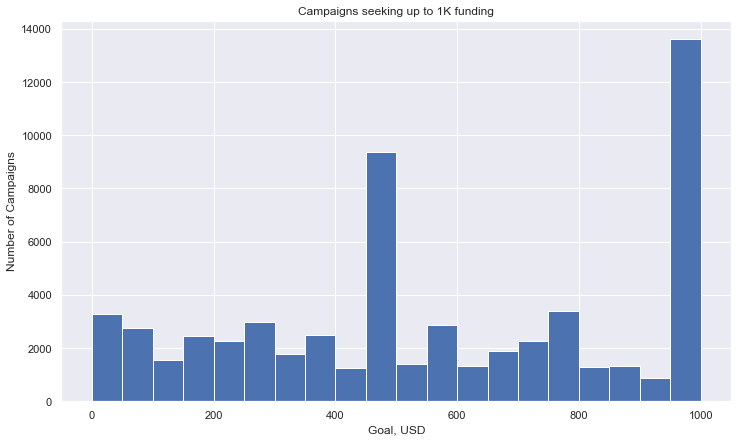

In [58]:
# Plotting the first bracket - up to 1K
plt.figure(figsize = (12, 7))

plt.hist(up_to_1K["usd_goal_real"], bins=20)
plt.title("Campaigns seeking up to 1K funding")
plt.xlabel("Goal, USD")
plt.ylabel("Number of Campaigns")
plt.show()

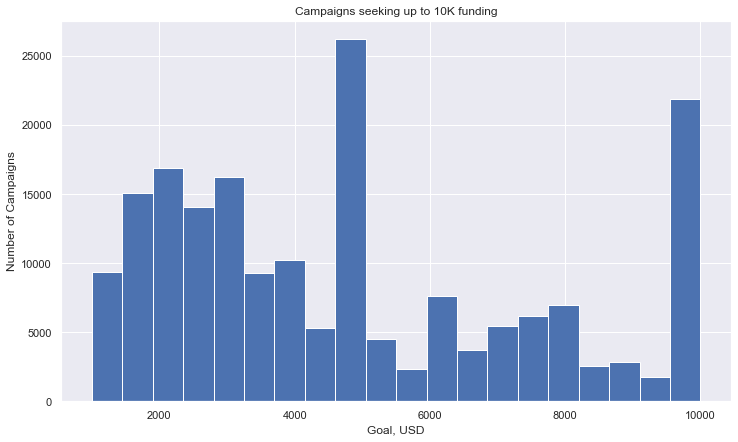

In [59]:
# Plotting the second bracket - up to 10K
plt.figure(figsize = (12, 7))

plt.hist(up_to_10K["usd_goal_real"], bins=20)
plt.title("Campaigns seeking up to 10K funding")
plt.xlabel("Goal, USD")
plt.ylabel("Number of Campaigns")
plt.show()

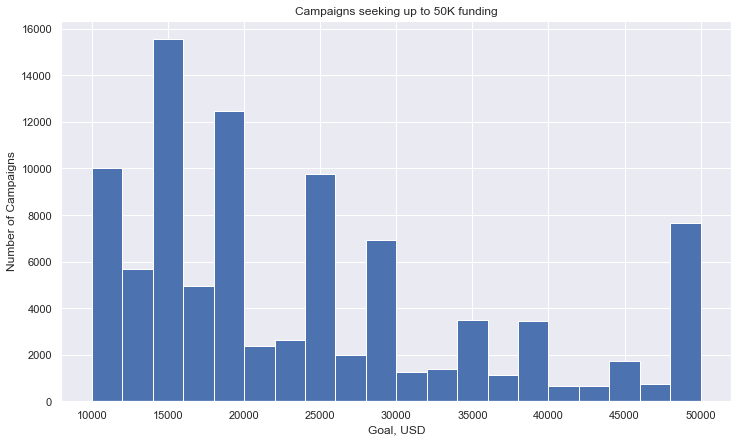

In [60]:
# Plotting the third bracket - up to 50K
plt.figure(figsize = (12, 7))

plt.hist(up_to_50K["usd_goal_real"], bins=20)
plt.title("Campaigns seeking up to 50K funding")
plt.xlabel("Goal, USD")
plt.ylabel("Number of Campaigns")
plt.show()

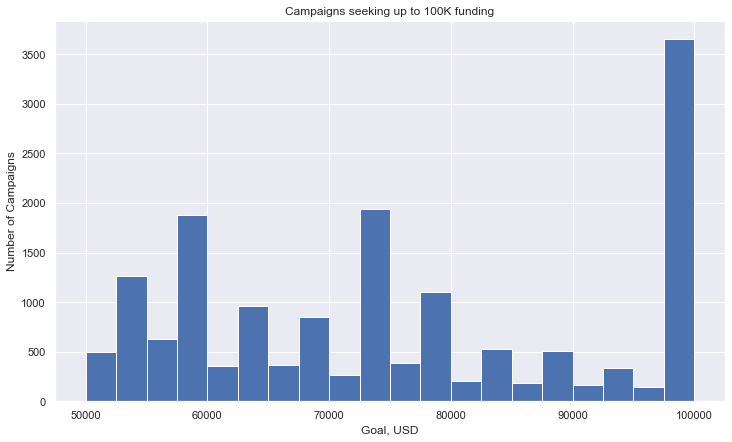

In [61]:
# Plotting the fourth bracket - up to 100K
plt.figure(figsize = (12, 7))

plt.hist(up_to_100K["usd_goal_real"], bins=20)
plt.title("Campaigns seeking up to 100K funding")
plt.xlabel("Goal, USD")
plt.ylabel("Number of Campaigns")
plt.show()

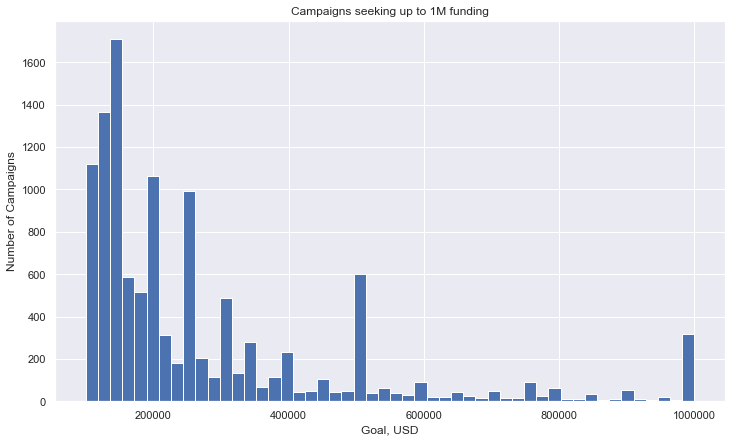

In [62]:
# Plotting the fifth bracket - up to 1M
plt.figure(figsize = (12, 7))

plt.hist(up_to_1M["usd_goal_real"], bins = 50)
plt.title("Campaigns seeking up to 1M funding")
plt.xlabel("Goal, USD")
plt.ylabel("Number of Campaigns")
# plt.yscale("log")
plt.show()

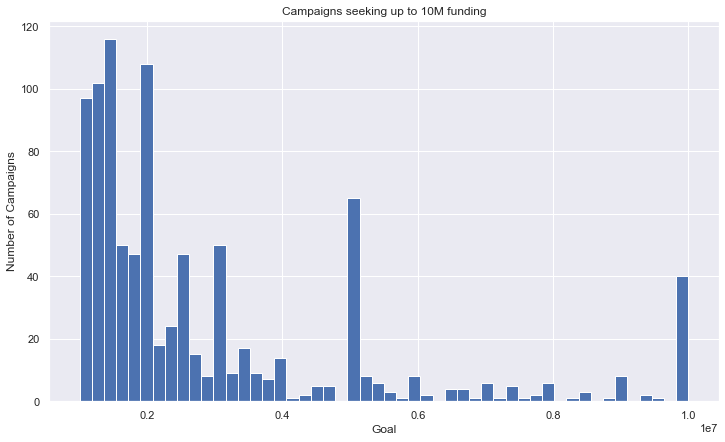

In [63]:
# Plotting the sixth bracket - up to 10M
plt.figure(figsize = (12, 7))

plt.hist(up_to_10M["usd_goal_real"], bins = 50)
plt.title("Campaigns seeking up to 10M funding")
plt.xlabel("Goal")
plt.ylabel("Number of Campaigns")
# plt.yscale("log")
plt.show()

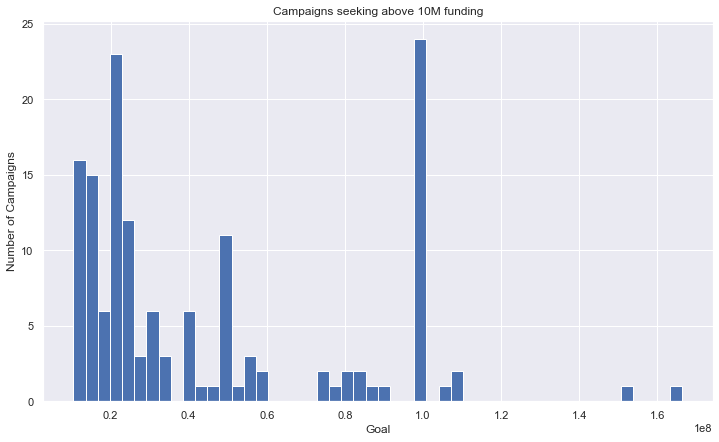

In [64]:
# Plotting the final bracket - above 10M
plt.figure(figsize = (12, 7))

plt.hist(above_10M["usd_goal_real"], bins = 50)
plt.title("Campaigns seeking above 10M funding")
plt.xlabel("Goal")
plt.ylabel("Number of Campaigns")
# plt.yscale("log")
plt.show()

#### Inspecting outliers

In [65]:
highest_goals = kickstart_data["usd_goal_real"].sort_values(ascending=False)
highest_goals.nlargest(5)

ID
1243678698    1.663614e+08
2000749004    1.513959e+08
944541075     1.101698e+08
2132015082    1.073699e+08
219702078     1.040572e+08
Name: usd_goal_real, dtype: float64

In [66]:
lowest_goals = kickstart_data["usd_goal_real"].sort_values(ascending=True)
lowest_goals.nsmallest(5)

ID
688564643     0.01
620302213     0.01
9572984       0.15
1379346088    0.49
219760504     0.50
Name: usd_goal_real, dtype: float64

In [67]:
lowest_100_projects = kickstart_data[kickstart_data["usd_goal_real"] < 10]
lowest_100_projects["state"].value_counts()

successful    515
failed        257
Name: state, dtype: int64

It seems there are some campaigns which seek very modest funding goals; the creators may be participating in kickstarter for publicity instead.

In [68]:
highest_projects = kickstart_data[kickstart_data["usd_goal_real"] > 10000000]
highest_projects["state"].value_counts()

failed    147
Name: state, dtype: int64

Unsurprisingly, all campaigns seeking funding of 10 000 000 USD or more have failed.

### Hypothesis Testing

**𝐻0**: Campaign success is not correlated with certain campaign goal amounts; the variation in the data is due to chance.<br>
**𝐻1**: The differences are not coincidental.<br>
Let's assume a 1% threshold value of  𝑝 (0.01). If 𝑝 ≤ 0.01%, we will reject 𝐻0.

In [69]:
success_by_goal = kickstart_data.groupby("state")["goal"]

In [70]:
successful_campaigns = success_by_goal.get_group("successful")
failed_campaigns = success_by_goal.get_group("failed")

In [71]:
test_result = ttest_ind(successful_campaigns, failed_campaigns, equal_var = False)
print(test_result)

print(test_result.pvalue)
if test_result.pvalue <= 0.01:
    print("The differences are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")
    
descriptives, test_result = rp.ttest(successful_campaigns, failed_campaigns)
print(test_result)

display(descriptives)

Ttest_indResult(statistic=-20.20014084881247, pvalue=1.1629104613890887e-90)
1.1629104613890887e-90
The differences are significant. Reject H0.
            Independent t-test      results
0  Difference (goal - goal) =   -61135.4560
1        Degrees of freedom =   372287.0000
2                         t =      -15.1482
3     Two side test p value =        0.0000
4    Difference > 0 p value =        0.0000
5    Difference < 0 p value =        1.0000
6                 Cohen's d =       -0.0517
7                 Hedge's g =       -0.0517
8             Glass's delta =       -1.9564
9                         r =        0.0248


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,goal,133956.0,10162.960544,3.124829e+04,85.377841,9995.621539,10330.299550
1,goal,238333.0,71298.416519,1.476923e+06,3025.282115,65368.942417,77227.890621
2,combined,372289.0,49300.825560,1.182219e+06,1937.572483,45503.240930,53098.410190


**Therefore**, we reject the null hypothesis and reach the conclusion that campaign goals do indeed have a strong correlation to success probability.<br/>
On the chart below, we can observe that the majority of kickstarter campaigns tend to seek funding below 50K USD, and the most common goal bracket is between 1k and 10k USD.

In [72]:
#Campaign goal brackets - for successful projects only
success_goals = kickstart_data[(kickstart_data["state"] == "successful")]

up_to_1K_goal = success_goals[(success_goals["usd_goal_real"] <= 1000)]

up_to_10K_goal = success_goals[(success_goals["usd_goal_real"] > 1000) & (success_goals["usd_goal_real"] <= 10000)]

up_to_50K_goal = success_goals[(success_goals["usd_goal_real"] > 10000) & (success_goals["usd_goal_real"] <= 50000)]

up_to_100K_goal = success_goals[(success_goals["usd_goal_real"] > 50000) & (success_goals["usd_goal_real"] <= 100000)]

up_to_1M_goal = success_goals[(success_goals["usd_goal_real"] > 100000) & (success_goals["usd_goal_real"] <= 1000000) ]

up_to_10M_goal = success_goals[(success_goals["usd_goal_real"] > 1000000) & (success_goals["usd_goal_real"] <= 10000000) ]

above_10M_goal = success_goals[(success_goals["usd_goal_real"] > 10000000)]

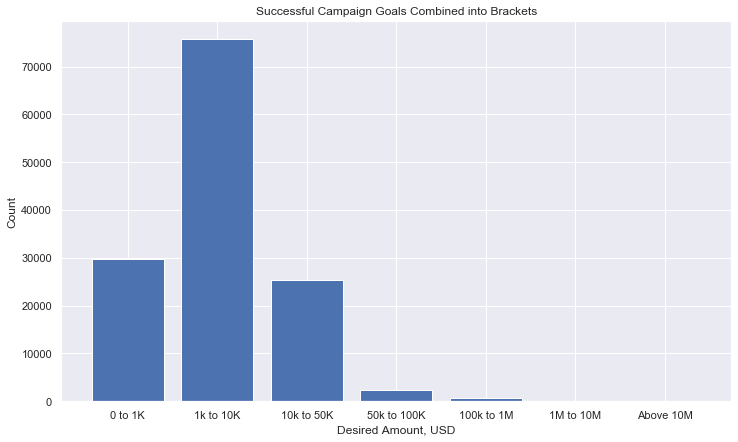

In [73]:
counts = up_to_1K_goal.shape[0], up_to_10K_goal.shape[0], up_to_50K_goal.shape[0],\
                up_to_100K_goal.shape[0], up_to_1M_goal.shape[0],\
                up_to_10M_goal.shape[0], above_10M_goal.shape[0]
labels = ["0 to 1K", "1k to 10K", "10k to 50K", "50k to 100K", "100k to 1M", "1M to 10M", "Above 10M"]

plt.bar(labels, counts)
plt.title("Successful Campaign Goals Combined into Brackets")
plt.xlabel("Desired Amount, USD")
plt.ylabel("Count")
fig = plt.gcf()
fig.set_size_inches(12, 7)
# plt.yscale("log")
plt.show()

## Modeling
First of all, we select the target and explanatory variables and convert the categorical ones to dummies. The target variable is converted to binary.<br>
The modeling approach itself is relatively uniform across all models being used - fitting and scoring a model, then trying to optimize its parameters through grid search and subsequently refitting and scoring the tuned one to compare the performances.<br>
We will focus mostly on F1 as an evaluation metric, since is better suited in case of imbalanced classes.


### Selecting Target and Explanatory Variables

In [74]:
kickstart_data["usd_goal_real"] = (minmax_scale(kickstart_data["usd_goal_real"], feature_range=(0,1)))

In [75]:
kickstart_features = kickstart_data[["main_category", "duration", "country", "usd_goal_real"]] # explanatory features

kickstart_output = kickstart_data["state"].copy(deep = True) # output feature

In [76]:
kickstart_features.columns

Index(['main_category', 'duration', 'country', 'usd_goal_real'], dtype='object')

#### Here it is important to note that we are **not** going to use any columns containing data about a campaign's number of backers or actual pledged amount, as that information is obtained post factum and would distort the models.

In [77]:
kickstart_features = pd.get_dummies(kickstart_features, columns = None)
pd.set_option('display.max_columns', 50)

# kickstart_features.head()
# kickstart_features.columns
kickstart_features.shape

(372289, 39)

In [78]:
kickstart_output.replace(["failed", "successful"], [0, 1], inplace=True)

In [79]:
kickstart_output.dtype

dtype('int64')

In [80]:
warnings.filterwarnings("ignore", category=FutureWarning)

kickstart_features_train, kickstart_features_test, kickstart_output_train,\
kickstart_output_test = train_test_split(kickstart_features, kickstart_output, train_size = 0.7, random_state = 1234)

In [81]:
assert kickstart_features_train.shape[0] == kickstart_output_train.shape[0]

In [82]:
assert kickstart_features_test.shape[0] == kickstart_output_test.shape[0]

## Logistic Regression

In [83]:
kickstart_regr = LogisticRegression(C = 1e4, fit_intercept = False, random_state = 1234)
x = kickstart_features_train
y = kickstart_output_train
kickstart_regr.fit(x, y)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1234, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluating and Fine-Tuning the Model

In [84]:
train_predictions = kickstart_regr.predict(kickstart_features_train)
test_predictions = kickstart_regr.predict(kickstart_features_test)

In [85]:
accuracy_score = kickstart_regr.score(kickstart_features_test, kickstart_output_test)

print(accuracy_score)

0.6597544924655511


In [86]:
f_1 = f1_score(kickstart_output_test, test_predictions)

print(f_1)

0.33965280553286875


#### Implementing and pickling the regression grid search:

In [91]:
# parameters = [{"C": [1e-8, 1e-5, 0.0001, 0.01, 0.1, 1, 10, 100, 10000, 1e6],
#                 "max_iter": [10, 20, 50, 100, 300, 1000],
#                 "fit_intercept": [True, False]}]

# regr_grid_search = GridSearchCV(LogisticRegression(), param_grid = parameters, cv=10, n_jobs=-1)
# regr_grid_search.fit(kickstart_features_train, kickstart_output_train)

# logreg_grid_pickle_out = open("logreg_grid.pickle", "wb")
# pickle.dump(regr_grid_search, logreg_grid_pickle_out)
# logreg_grid_pickle_out.close()

# print(regr_grid_search.best_params_)

In [90]:
logreg_grid_pickle_in = open("logreg_grid.pickle", "rb")
regr_grid_search = pickle.load(logreg_grid_pickle_in)

logreg_grid_pickle_in.close()

print(regr_grid_search.best_params_)

{'C': 10000, 'fit_intercept': False, 'max_iter': 10}


In [92]:
regr_grid_search_best_params = regr_grid_search.best_params_

In [97]:
# # Implementing the grid search and pickling the model

# C_best = regr_grid_search_best_params["C"]
# max_iter_best = regr_grid_search_best_params["max_iter"]
# fit_intercept_best = regr_grid_search_best_params["fit_intercept"]

# model_tuned = LogisticRegression(C = C_best, max_iter = 50, fit_intercept = fit_intercept_best)
# model_tuned.fit(kickstart_features_train, kickstart_output_train)

# # Pickling the tuned model

# logreg_tuned_pickle_out = open("logreg_tuned.pickle", "wb")
# pickle.dump(model_tuned, logreg_tuned_pickle_out)
# logreg_tuned_pickle_out.close()

In [96]:
# Loading the pickle file

logreg_tuned_pickle_in = open("logreg_tuned.pickle", "rb")
model_tuned = pickle.load(logreg_tuned_pickle_in)

logreg_tuned_pickle_in.close()

In [98]:
tuned_accuracy = model_tuned.score(kickstart_features_test, kickstart_output_test)
tuned_accuracy

0.6597544924655511

In [99]:
tuned_test_predictions = model_tuned.predict(kickstart_features_test)

tuned_f1 = f1_score(kickstart_output_test, tuned_test_predictions)
tuned_f1

0.33965280553286875

### Logistic Regression Confusion Matrix & Classification Report

In [100]:
cfm = confusion_matrix(kickstart_output_test, tuned_test_predictions)
print(cfm)

[[63913  7582]
 [30419  9773]]


In [101]:
print(classification_report(kickstart_output_test, tuned_test_predictions))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77     71495
           1       0.56      0.24      0.34     40192

    accuracy                           0.66    111687
   macro avg       0.62      0.57      0.56    111687
weighted avg       0.64      0.66      0.62    111687



### ROC Curve

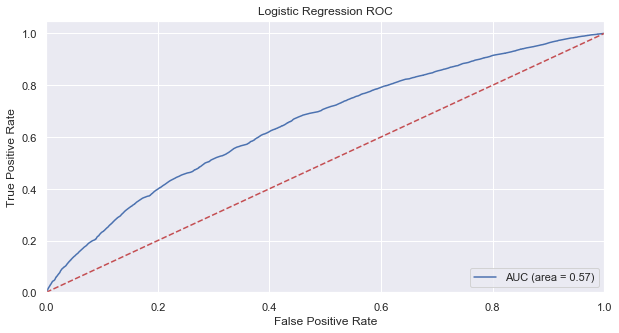

In [102]:
logit_roc_auc = roc_auc_score(kickstart_output_test, model_tuned.predict(kickstart_features_test))
false_pos_rate, true_pos_rate, thresholds = roc_curve(kickstart_output_test,\
                                                      model_tuned.predict_proba(kickstart_features_test)[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.figure(figsize = (10, 5))
plt.plot(false_pos_rate, true_pos_rate, label = "AUC (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC")
plt.legend(loc = "lower right")
# plt.savefig("Log_ROC")


In [180]:
# Preparing the cross-validation folds

k_fold = StratifiedKFold(n_splits = 10, shuffle=False, random_state = 0)

k_fold = k_fold.get_n_splits(kickstart_features_train, kickstart_output_train)

## K Nearest Neighbors

In [151]:
# # Instantiating and pickling the model

# knn_model = neighbors.KNeighborsClassifier(n_neighbors = 36, weights = "uniform", p = 2)

# knn_model.fit(kickstart_features_train, kickstart_output_train)


# knn_model_pickle_out = open("knn_model.pickle", "wb")
# pickle.dump(knn_model, knn_model_pickle_out)
# knn_model_pickle_out.close()

In [150]:
# Loading the pickle file

knn_model_pickle_in = open("knn_model.pickle", "rb")
knn_model = pickle.load(knn_model_pickle_in)

knn_model_pickle_in.close()

In [155]:
# Setting up a grid search for the k and weights parameters

k_range = list(range(30, 40))

weight_options = ["uniform", "distance"]

Regarding the weights parameter, the default option is "uniform" (i.e. all points in the neighborhood are weighted equally). Another option is "distance", which weights closer neighbors more heavily than neighbors located further away.

In [156]:
knn_parameter_grid = dict(n_neighbors = k_range, weights = weight_options)
# print(knn_parameter_grid)

In [185]:
# # Implementing the kNN grid search + pickling:

# knn_grid = GridSearchCV(knn_model, knn_parameter_grid, cv=3, scoring = "accuracy", n_jobs = -1, verbose = 5)
# knn_grid.fit(kickstart_features_train.head(40000), kickstart_output_train.head(40000))

# knn_grid_pickle_out = open("knn_grid.pickle", "wb")
# pickle.dump(knn_grid, knn_grid_pickle_out)
# knn_grid_pickle_out.close()

*Due to computational complexity, the knn search grid was executed using only a 40 k sample of the data.*

In [162]:
knn_grid_pickle_in = open("knn_grid.pickle", "rb")
knn_grid = pickle.load(knn_grid_pickle_in)

knn_grid_pickle_in.close()

In [163]:
# Single best score achieved across all parameters
print("Best score:", knn_grid.best_score_)

# Dictionary with all (k) parameters used to generate that score
print(knn_grid.best_params_)

# Actual model fitted with the best parameters
print(knn_grid.best_estimator_)

Best score: 0.66125
{'n_neighbors': 34, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=34, p=2,
                     weights='uniform')


#### Visualizing the accuracy per each k value we searched for

In [167]:
# # Preparing the values for the chart

# k_range = range(30, 40)

# k_scores = []

# # Looping through values of k
# for k in k_range:
#     knn = neighbors.KNeighborsClassifier(n_neighbors = k)
# # obtaining cross_val_score for each k neighbour
#     scores = cross_val_score(knn, kickstart_features_train, kickstart_output_train,\
#                              cv=3, scoring="accuracy", verbose = 5, n_jobs = -1)
# # appending the mean of scores for k neighbors to k_scores list
#     k_scores.append(scores.mean())

# # Pickling the K-scores:

# k_scores_pickle_out = open("k_scores.pickle", "wb")
# pickle.dump(k_scores, k_scores_pickle_out)
# k_scores_pickle_out.close()
    
# print(k_scores)

In [166]:
k_scores_pickle_in = open("k_scores.pickle", "rb")
k_scores = pickle.load(k_scores_pickle_in)

k_scores_pickle_in.close()


In [168]:
print(k_scores)

[0.6719365219241427, 0.6713686101918901, 0.6726694352261019, 0.6719403631394677, 0.6731759611957887, 0.6721782723507456, 0.6730838696530618, 0.6726387412846373, 0.6724507181323888, 0.6728037440028745]


Text(0.5, 1.0, 'k value accuracy variation')

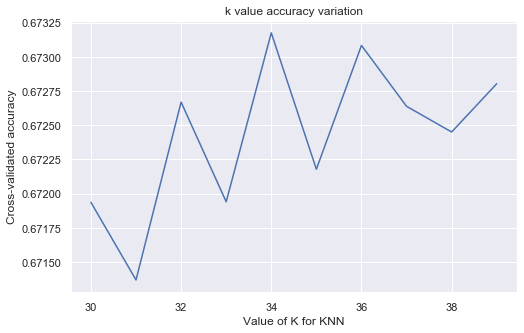

In [169]:
# Plotting the values of k for kNN vs the cross-validated accuracy

plt.figure(figsize = (8, 5))
plt.plot(k_range, k_scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross-validated accuracy")
plt.title("k value accuracy variation")

Based on the chart above, the accuracy peaks at k = 34 out of all the values used in the grid search.

In [170]:
tuned_knn = knn_grid.best_estimator_
tuned_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=34, p=2,
                     weights='uniform')

In [171]:
prediction_on_train_data = tuned_knn.predict(kickstart_features_train)
print("kNN Accuracy Score - Train Data:", metrics.accuracy_score(kickstart_output_train, prediction_on_train_data)* 100,"%")

kNN Accuracy Score - Train Data: 67.04284694668499 %


In [172]:
predicted_output = tuned_knn.predict(kickstart_features_test)
knn_accuracy = metrics.accuracy_score(kickstart_output_test, predicted_output)
print("kNN Accuracy Score - Test Data:", metrics.accuracy_score(kickstart_output_test, predicted_output)* 100,"%")

kNN Accuracy Score - Test Data: 66.77142371090638 %


In [173]:
# Predict
tuned_knn_y_pred = tuned_knn.predict(kickstart_features_test)

# Calculate the F1 score
tuned_knn_f1_score = f1_score(tuned_knn_y_pred, kickstart_output_test)

In [174]:
print("kNN F1 Score: {:.2f}".format(tuned_knn_f1_score * 100), "%")

kNN F1 Score: 43.04 %


### kNN Confusion Matrix & Classification Report

In [175]:
knn_predicted = tuned_knn.predict(kickstart_features_test)

In [176]:
print(classification_report(kickstart_output_test, knn_predicted))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77     71495
           1       0.56      0.35      0.43     40192

    accuracy                           0.67    111687
   macro avg       0.63      0.60      0.60    111687
weighted avg       0.65      0.67      0.64    111687



In [177]:
conf_matrix = confusion_matrix(kickstart_output_test, knn_predicted, [0, 1])

In [178]:
total_accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / float(np.sum(conf_matrix))
class1_accuracy = (conf_matrix[0, 0] / float(np.sum(conf_matrix[0, :])))
class2_accuracy = (conf_matrix[1, 1] / float(np.sum(conf_matrix[1, :])))
print(conf_matrix)
print("Total accuracy: %.5f" % total_accuracy)
print("Class1 accuracy: %.5f" % class1_accuracy)
print("Class2 accuracy: %.5f" % class2_accuracy)
print("Geometric mean accuracy: %.5f" % math.sqrt((class1_accuracy * class2_accuracy)))

[[60554 10941]
 [26171 14021]]
Total accuracy: 0.66771
Class1 accuracy: 0.84697
Class2 accuracy: 0.34885
Geometric mean accuracy: 0.54357


Text(0.5, 1.0, 'ROC Curve of kNN')

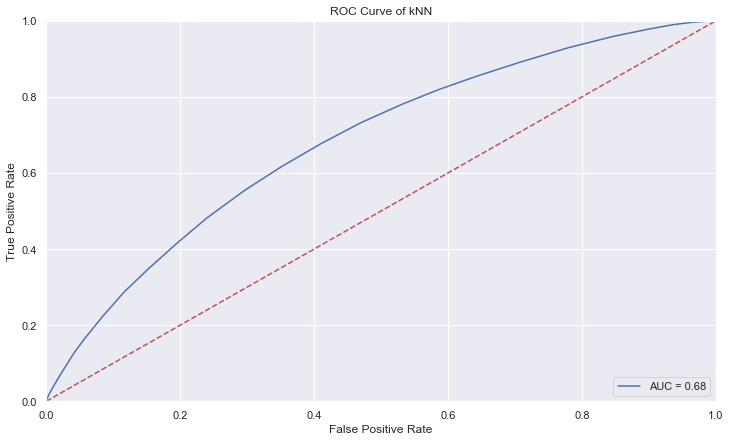

In [179]:
y_scores = tuned_knn.predict_proba(kickstart_features_test)
false_pos_rate, true_pos_rate, threshold = roc_curve(kickstart_output_test, y_scores[:, 1])
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.figure(figsize = (12, 7))
plt.plot(false_pos_rate, true_pos_rate, "b", label = "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve of kNN")
# plt.savefig("kNN_ROC")

## Decision Tree Classifier

In [103]:
dtree_clf = DecisionTreeClassifier(random_state = 0)

dtree_clf.fit(kickstart_features_train, kickstart_output_train)

# Predict
tree_y_pred = dtree_clf.predict(kickstart_features_test)

# Calculate the F1 score
tree_score = f1_score(tree_y_pred, kickstart_output_test)

print("Decision Tree F1 score: {:.2f}".format(tree_score * 100),"%")

Decision Tree F1 score: 43.16 %


In [106]:
# # Optimizing parameters through GridSearch:

# tree_param_grid = {"criterion":["gini","entropy"], "max_depth":list(range(2, 21))}

# # Instantiating and fitting
# tree_grid = GridSearchCV(dtree_clf, tree_param_grid, cv=10, scoring = "f1", n_jobs = -1)
# tree_grid.fit(kickstart_features_train, kickstart_output_train)

# # Pickling the decision tree search grid:

# tree_grid_pickle_out = open("tree_grid.pickle", "wb")
# pickle.dump(tree_grid, tree_grid_pickle_out)
# tree_grid_pickle_out.close()
    

In [105]:
tree_grid_pickle_in = open("tree_grid.pickle", "rb")
tree_grid = pickle.load(tree_grid_pickle_in)

tree_grid_pickle_in.close()

In [107]:
# The best score achieved across all parameters:
print(tree_grid.best_score_)

# Parameters used to generate that score:
print(tree_grid.best_params_)

# Actual model fitted with the best parameters:
print(tree_grid.best_estimator_)

0.4524362377351535
{'criterion': 'gini', 'max_depth': 17}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')


In [110]:
# # Tuned model 
# tuned_dtree = tree_grid.best_estimator_

# tuned_dtree.fit(kickstart_features_train, kickstart_output_train)

# # Pickling the tuned model

# tuned_dtree_pickle_out = open("tuned_dtree.pickle", "wb")
# pickle.dump(tuned_dtree, tuned_dtree_pickle_out)
# tuned_dtree_pickle_out.close()


In [109]:
tuned_dtree_pickle_in = open("tuned_dtree.pickle", "rb")
tuned_dtree = pickle.load(tuned_dtree_pickle_in)

tuned_dtree_pickle_in.close()

In [125]:
# Predict
tuned_tree_y_pred = tuned_dtree.predict(kickstart_features_test)

# Accuracy score
tuned_tree_accuracy = metrics.accuracy_score(kickstart_output_test, tuned_tree_y_pred)
print("Tuned Decision Tree Accuracy: {:.2f}".format(tuned_tree_accuracy * 100),"%")

# Calculate the F1 score
tuned_dtree_score = f1_score(tuned_tree_y_pred, kickstart_output_test)

print("Tuned Decision Tree F1 score: {:.2f}".format(tuned_dtree_score * 100),"%")

Tuned Decision Tree Accuracy: 67.30 %
Tuned Decision Tree F1 score: 45.02 %


### Decision Tree Confusion Matrix & Classification Report

In [126]:
tree_confusion_matrix = confusion_matrix(kickstart_output_test, tuned_tree_y_pred, [0, 1])
tree_confusion_matrix

array([[60214, 11281],
       [25240, 14952]], dtype=int64)

In [127]:
print(classification_report(kickstart_output_test, tuned_tree_y_pred))

              precision    recall  f1-score   support

           0       0.70      0.84      0.77     71495
           1       0.57      0.37      0.45     40192

    accuracy                           0.67    111687
   macro avg       0.64      0.61      0.61    111687
weighted avg       0.66      0.67      0.65    111687



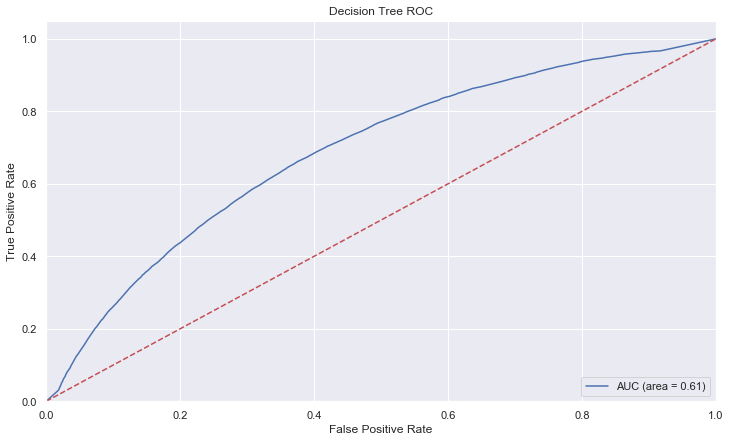

In [128]:
dtree_roc_auc = roc_auc_score(kickstart_output_test, tuned_dtree.predict(kickstart_features_test))
false_pos_rate, true_pos_rate, thresholds = roc_curve(kickstart_output_test,\
                                                      tuned_dtree.predict_proba(kickstart_features_test)[:,1])

roc_auc = auc(false_pos_rate, true_pos_rate)
plt.figure(figsize = (12, 7))
plt.plot(false_pos_rate, true_pos_rate, label = "AUC (area = %0.2f)" % dtree_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC")
plt.legend(loc = "lower right")
# plt.savefig("DTree_ROC")


## Random Forest Classifier

**Random Forests comapred to Decision Trees:**
- Random forests are a set of multiple decision trees;
- Deep decision trees may suffer from overfitting, but random forests prevent overfitting by creating trees on random subsets;
- Decision trees are computationally faster;
- Random forests are difficult to interpret, while a decision tree is easily interpretable and can be converted to rules.

In [129]:
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 0)

forest_clf.fit(kickstart_features_train, kickstart_output_train)

forest_y_pred = forest_clf.predict(kickstart_features_test)

In [130]:
print("Random Forest Accuracy: {:.2f}".format(metrics.accuracy_score(kickstart_output_test, forest_y_pred) * 100), "%")

Random Forest Accuracy: 65.57 %


In [131]:
forest_f1_score = f1_score(forest_y_pred, kickstart_output_test)
print("Random Forest F1 Score: {:.2f}".format((forest_f1_score) * 100), "%")

Random Forest F1 Score: 45.34 %


In [134]:
# # Implementing the gridsearch

# forest_params = {"n_estimators": [100, 200, 300],
#                 "max_depth": [20, 50, 100]}

# rfc = RandomForestClassifier()
# forest_grid = GridSearchCV(rfc, forest_params, scoring = "f1", cv = 10, n_jobs = -1)
# forest_grid.fit(kickstart_features_train, kickstart_output_train)

# # Pickling the random forest search grid result:

# forest_grid_pickle_out = open("forest_grid.pickle", "wb")
# pickle.dump(forest_grid, forest_grid_pickle_out, pickle.HIGHEST_PROTOCOL)
# forest_grid_pickle_out.close()


In [133]:
forest_grid_pickle_in = open("forest_grid.pickle", "rb")
forest_grid = pickle.load(forest_grid_pickle_in)

forest_grid_pickle_in.close()

In [135]:
# Single best score achieved across all parameters
print("Random forest; best score:", forest_grid.best_score_)

# Dictionary with all (k) parameters used to generate that score
print(forest_grid.best_params_)

# Actual model fitted with the best parameters
print(forest_grid.best_estimator_)

Random forest; best score: 0.4507672684385366
{'max_depth': 50, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [138]:
# # Tuned model
# tuned_forest = forest_grid.best_estimator_

# tuned_forest.fit(kickstart_features_train, kickstart_output_train)

# # Pickling the tuned model

# tuned_forest_pickle_out = open("tuned_forest.pickle", "wb")
# pickle.dump(tuned_forest, tuned_forest_pickle_out, pickle.HIGHEST_PROTOCOL)
# tuned_forest_pickle_out.close()


### ! Please note - the pickled Random Forest search grid and model have been uploaded [here](https://drive.google.com/file/d/1gnIlt_Dhw-TsU4rt_i9MOIaN6-2u4iXZ/view?usp=sharing).

In [137]:
tuned_forest_pickle_in = open("tuned_forest.pickle", "rb")
tuned_forest = pickle.load(tuned_forest_pickle_in)

tuned_forest_pickle_in.close()

In [139]:
# Predict
tuned_forest_y_pred = tuned_forest.predict(kickstart_features_test)

tuned_forest_accuracy = metrics.accuracy_score(kickstart_output_test, tuned_forest_y_pred)
print("Tuned Random Forest Accuracy: {:.2f}".format(metrics.accuracy_score(kickstart_output_test, tuned_forest_y_pred) * 100), "%")

# Calculate the F1 score
tuned_forest_f1_score = f1_score(tuned_forest_y_pred, kickstart_output_test)

print("Tuned Random Forest F1 score: {:.2f}".format(tuned_forest_f1_score * 100),"%")

Tuned Random Forest Accuracy: 65.61 %
Tuned Random Forest F1 score: 45.37 %


### Random Forest Confusion Matrix & Classification Report

In [140]:
forest_confusion_matrix = confusion_matrix(kickstart_output_test, tuned_forest_y_pred, [0, 1])
forest_confusion_matrix

array([[57334, 14161],
       [24243, 15949]], dtype=int64)

In [141]:
print(classification_report(kickstart_output_test, tuned_forest_y_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75     71495
           1       0.53      0.40      0.45     40192

    accuracy                           0.66    111687
   macro avg       0.62      0.60      0.60    111687
weighted avg       0.64      0.66      0.64    111687



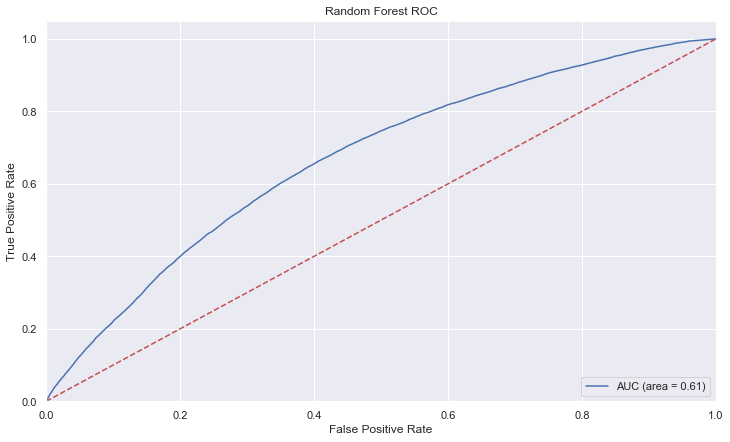

In [142]:
tuned_forest_roc_auc = roc_auc_score(kickstart_output_test, tuned_forest.predict(kickstart_features_test))
false_pos_rate, true_pos_rate, thresholds = roc_curve(kickstart_output_test,\
                                                      tuned_forest.predict_proba(kickstart_features_test)[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.figure(figsize = (12, 7))
plt.plot(false_pos_rate, true_pos_rate, label = "AUC (area = %0.2f)" % dtree_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC")
plt.legend(loc = "lower right")
# plt.savefig("Random Forest ROC")


### Comparing Scores

In [181]:
print("Accuracy scores at a glance:")

print("Logistic Regression: {:.2f}".format(accuracy_score * 100), "%")
print("kNN: {:.2f}".format(knn_accuracy * 100), "%")
print("Decision tree: {:.2f}".format(tuned_tree_accuracy * 100), "%")
print("Random forest: {:.2f}".format(tuned_forest_accuracy * 100), "%")

Accuracy scores at a glance:
Logistic Regression: 65.98 %
kNN: 66.77 %
Decision tree: 67.30 %
Random forest: 65.61 %


In [182]:
# Compare accuracy across all models

modelsDict = {"Logistic Regression": accuracy_score, "kNN": knn_accuracy, "Decision tree": tuned_tree_accuracy, "Random forest": tuned_forest_accuracy}
best_classifier_acc = max(modelsDict, key=modelsDict.get)
print("The model with the highest accuracy score is:", best_classifier_acc)

The model with the highest accuracy score is: Decision tree


In [183]:
print("F1 testing scores at a glance:")

print("Logistic Regression: {:.2f}".format(tuned_f1 * 100), "%")
print("kNN: {:.2f}".format(tuned_knn_f1_score * 100), "%")
print("Decision tree: {:.2f}".format(tuned_dtree_score * 100), "%")
print("Random forest: {:.2f}".format(tuned_forest_f1_score * 100), "%")


F1 testing scores at a glance:
Logistic Regression: 33.97 %
kNN: 43.04 %
Decision tree: 45.02 %
Random forest: 45.37 %


In [184]:
# Compare F1 across all models

modelsDict = {"Logistic Regression": tuned_f1, "kNN": tuned_knn_f1_score, "Decision tree": tuned_dtree_score, "Random forest": tuned_forest_f1_score}
best_classifier_f1 = max(modelsDict, key=modelsDict.get)
print("The model with the highest F1 score is:", best_classifier_f1)

The model with the highest F1 score is: Random forest


### Conclusion

 To sumarize the findings of the present research, despite trying out multiple models and hypertuning parameters, all of them were underfitted and produced poor scores, unable to accurately capture the relationships between the dataset’s features and target variable.<br>
In terms of accuracy, the best score was 67.30% for the decision tree model; however, a better evaluation metric would be the F1 score. The best F1 score belonged to the Random Forest model, but it only amounted to 45.37%.<br>It can be concluded that the algorithms suffer from high bias and are too simple to establish a stable learning pattern. The underfitting may have ocurred because the explanatory features are insufficient for the models to detect the underlying trends of the data. Typically, such models could benefit from increasing the size or number of parameters, or increasing the complexity of the model.<br>
Moreover, external factors influencing success may exist which are not part of the current dataset. Future improvements could be explored with additional attributes - if and when they are made available.

### References
- Success Prediction on Crowdfunding with Multimodal Deep Learning - Chaoran Cheng, Fei Tan, Xiurui Hou and Zhi Wei; Department of Computer Science, New Jersey Institute of Technology, USA
- KickPredict: Predicting Kickstarter Success - Kevin Chen, Brock Jones, Isaac Kim, Brooklyn Schlamp; Dept. of Computing and Mathematical Sciences, California Institute of Technology
- Launch Hard or Go Home! Predicting the Success of Kickstarter Campaigns - Vincent Etter, Matthias Grossglauser, Patrick Thiran; School of Computer and Communication Sciences, École Polytechnique Fédérale de Lausanne (EPFL), Lausanne, Switzerland
- [The elements of a successful crowdfunding campaign: A systematic literature review of crowdfunding performance](https://www.academia.edu/34482768/The_elements_of_a_successful_crowdfunding_campaign_A_systematic_literature_review_of_crowdfunding_performance)
- Predicting Kickstarter Campaign Success - Rachel Downs, Muhammad Ghauri
- https://www.alleywatch.com/2013/07/kickstarter-statistics-dissected/
- https://www.kicktraq.com/
- [Understanding Random Forests Classifiers in Python](https://www.datacamp.com/community/tutorials/random-forests-classifier-python)